In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


In [2]:
# Define super parameters
batch_size=15
epochs=20
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")


In [3]:
# dowload data

trainsets=datasets.MNIST(root="./data",train=True,transform=transforms.ToTensor())
testsets=datasets.MNIST(root="./data",train=False,transform=transforms.ToTensor())


/home/sun/.pyenv/versions/DataVisualization/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# check data

classes=trainsets.classes
classes
print(trainsets.data.shape)
print(trainsets.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [5]:
# 
train_loader=torch.utils.data.DataLoader(dataset=trainsets,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=testsets,batch_size=batch_size,shuffle=True)


In [6]:
len(train_loader)
print(type(train_loader))
images, labels=next(iter(train_loader))
print(images.shape)
print(labels.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([15, 1, 28, 28])
torch.Size([15])


<class 'torch.Tensor'>
torch.Size([15, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([3, 62, 242])
(62, 242, 3)


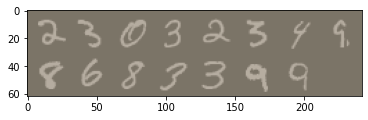

In [7]:
def image_show(imgs,titles=None):
    imgs=imgs.numpy().transpose((1,2,0))
    print(imgs.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs=np.clip(imgs,0,1)
    plt.imshow(imgs)
    plt.show()

print(type(images))
print(images.shape)
imgs=torchvision.utils.make_grid(images)
print(type(imgs))
print(imgs.shape)
image_show(imgs)
    
    

In [8]:
class LSTM_Model(nn.Module):
    def __init__(self,input_dim,hidden_dim, layer_dim,output_dim):
        super(LSTM_Model,self).__init__()
        self.hidden_dim=hidden_dim
        self.layer_dim=layer_dim
        self.lstm=nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim)
        
    def forward(self,x):
        #layer_dim, batch_size, hidden_dim
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        out=self.fc(out[:,-1,:])
        return out

    

In [9]:
input_dim =28
hidden_dim =100
layer_dim=1
output_dim=10
learning_rate=0.01

model=LSTM_Model(input_dim,hidden_dim,layer_dim,output_dim)
    

In [10]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [11]:
print(len(list(model.parameters())))
for idx,pa in enumerate(list(model.parameters())):
    print("第"+str(idx)+"参数:",pa.size(),type(pa))


6
第0参数: torch.Size([400, 28]) <class 'torch.nn.parameter.Parameter'>
第1参数: torch.Size([400, 100]) <class 'torch.nn.parameter.Parameter'>
第2参数: torch.Size([400]) <class 'torch.nn.parameter.Parameter'>
第3参数: torch.Size([400]) <class 'torch.nn.parameter.Parameter'>
第4参数: torch.Size([10, 100]) <class 'torch.nn.parameter.Parameter'>
第5参数: torch.Size([10]) <class 'torch.nn.parameter.Parameter'>


In [12]:
#模型训练
sequence_dim=28
loss_list=[]
accuracy_list=[]
iteration_list=[] # save iteration/epoch

iter=0
for epoch in range(epochs):
    for i, (images, targets) in enumerate(train_loader):
        model.train()
        images=images.view(-1,sequence_dim,input_dim).requires_grad_().to(device)
        targets=targets.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        
        loss=criterion(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        iter+=1
        
        if iter %500==0:
            model.eval()
            correct=.0
            total=0
            for images, targets in test_loader:
                images=images.view(-1,sequence_dim,input_dim).requires_grad_().to(device)
                targets=targets.to(device)
                outputs=model(images)
                predict=torch.max(outputs.data,dim=1)[1]
                
                total+=targets.size(0)
                if torch.cuda.is_available():
                    correct+=(predict.gpu()==targets.gpu()).sum()
                else:
                    correct+=(predict.cpu()==targets.cpu()).sum()


                       # 计算
            accuracy = correct / total * 100
            # 保存accuracy, loss, iteration
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print("loop : {}, Loss : {}, Accuracy : {}".format(iter, loss.item(), accuracy))
                
                

            
            
            

loop : 500, Loss : 2.3030807971954346, Accuracy : 11.350000381469727
loop : 1000, Loss : 2.272383451461792, Accuracy : 11.350000381469727
loop : 1500, Loss : 2.3035364151000977, Accuracy : 11.350000381469727
loop : 2000, Loss : 2.2971816062927246, Accuracy : 13.539999961853027
loop : 2500, Loss : 2.2825663089752197, Accuracy : 17.649999618530273
loop : 3000, Loss : 2.30265474319458, Accuracy : 14.30000114440918


KeyboardInterrupt: 

In [ ]:
# 可视化 loss
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('LSTM')
plt.show()

In [ ]:
# 可视化 accuracy
plt.plot(iteration_list, accuracy_list, color='r')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTM_mnist.png')
plt.show()